# Sentiment Analysis - Bert

In [1]:
#We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import tensorflow_hub as hub
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
import tokenization
import warnings
warnings.simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlpweek1/train.csv
/kaggle/input/nlpweek1/test.csv


### defining necessary functions

In [3]:
"""for eda purpose below function takes text and breaks it down into tokens,filters stopwords
and generates a word cloud"""
def word_cloud(text,title):
    stopwords = set(STOPWORDS)
    stopwords.update(["br", "now", "film", "movie", "going", "know"])                
    wordcloud = WordCloud(stopwords=stopwords,max_words=1000,width=800, height=400,background_color="white").generate(text)
    plt.figure(figsize=[14,8])
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [4]:
""" below mentioned function encodes our files as inputs to BERT model"""

def bert_encoder(texts, tokenizer, max_len=512): #max limit of tokens = 512
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2] #since we are adding a [CLS] and a [SEP] token
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [5]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(3, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Load, EDA and Preprocess

In [6]:
train = pd.read_csv("/kaggle/input/nlpweek1/train.csv")
test = pd.read_csv("/kaggle/input/nlpweek1/test.csv")

### Let's find out what words are most commonly used in each kind of review in the train dataset (a **Word Cloud** from each type of reviews will give us some idea).

In [7]:
positive = " ".join(review for review in train[train["Sentiment"]==2].Review)
neutral = " ".join(review for review in train[train["Sentiment"]==1].Review)
negative = " ".join(review for review in train[train["Sentiment"]==0].Review)

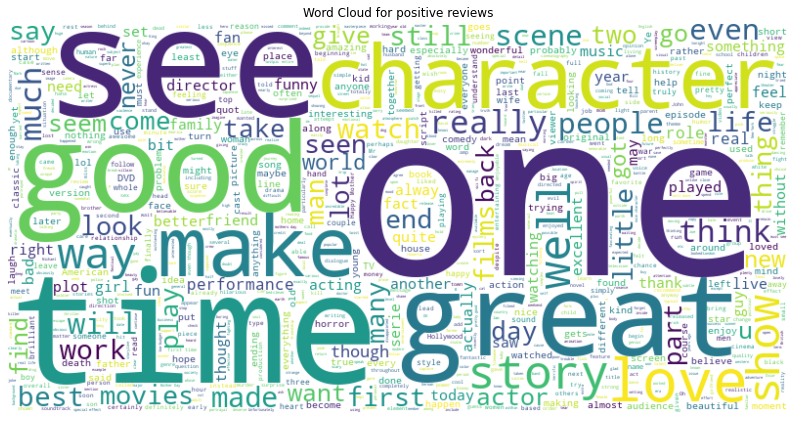

In [8]:
word_cloud(positive, "Word Cloud for positive reviews")

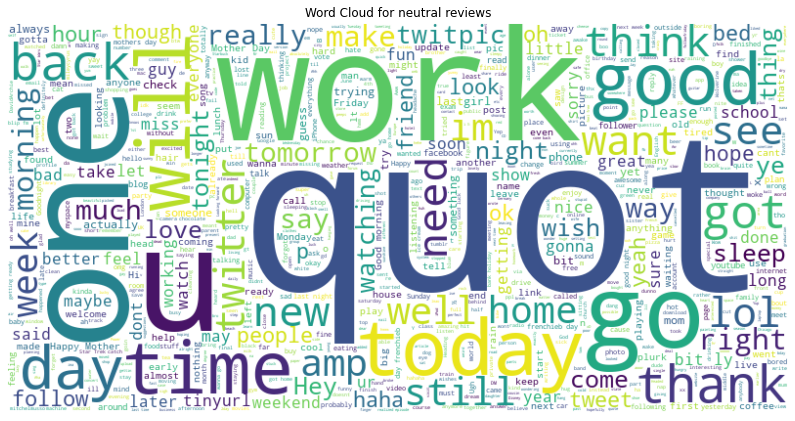

In [9]:
word_cloud(neutral,"Word Cloud for neutral reviews")

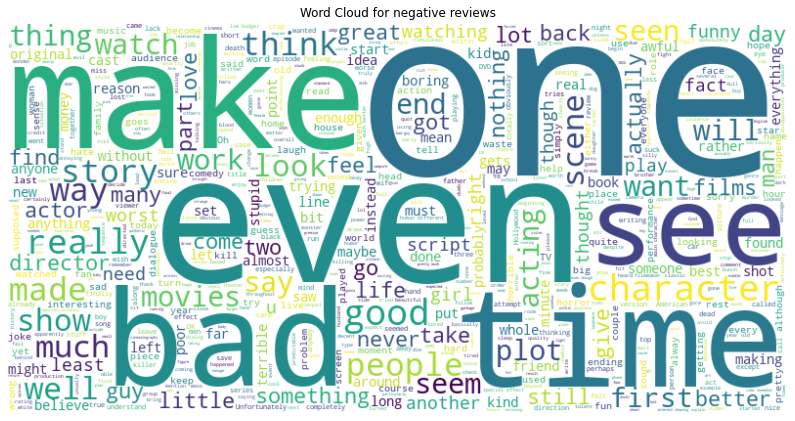

In [10]:
word_cloud(negative,"Word Cloud for negative reviews")

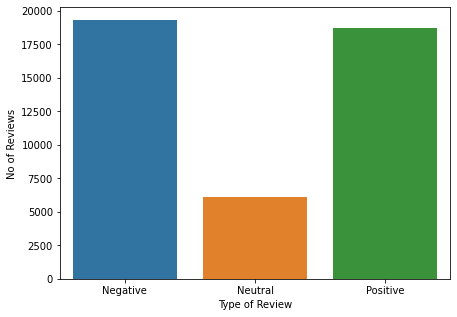

In [11]:
plt.figure(figsize=(7,5))
sns.countplot(train.Sentiment)
plt.xlabel("Type of Review")
plt.ylabel("No of Reviews")
plt.xticks([0,1,2],labels=["Negative","Neutral","Positive"]);

In [12]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)


CPU times: user 24.1 s, sys: 4.7 s, total: 28.8 s
Wall time: 45.8 s


In [13]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [25]:
%%time
train_input = bert_encoder(train.Review.values, tokenizer, max_len=160)
test_input = bert_encoder(test.Review.values, tokenizer, max_len=160)

CPU times: user 2min 12s, sys: 36.9 ms, total: 2min 12s
Wall time: 2min 12s


In [15]:
a=[]
for i in range(len(train)):
    a.append(len(train.Review[i].split()))

In [16]:
print(train.Review.values[:1])
bert_encoder(train.Review.values[:1],tokenizer,max_len=192)

["Today I'm working on my &quot;Quirky Q&quot; cue or maybe it will become a concerto"]


(array([[  101,  2651,  1045,  1005,  1049,  2551,  2006,  2026,  1004,
         22035,  2102,  1025, 21864, 15952,  1053,  1004, 22035,  2102,
          1025, 16091,  2030,  2672,  2009,  2097,  2468,  1037, 10405,
           102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,

In [17]:
train_labels = train.Sentiment
train_labels = pd.get_dummies(train_labels)

In [24]:
train_input

3

## Load and train model

In [26]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [27]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=1,
    batch_size=16
)

2205/2205 [==============================] - 2208s 992ms/step - loss: 0.5706 - accuracy: 0.7616 - val_loss: 0.6181 - val_accuracy: 0.7344


## Predict

In [29]:
test_pred = model.predict(test_input)

## Generate submissions

In [30]:
submit = pd.DataFrame(test_pred,columns=["Negative_0","Neutral_1","Positive_2"])

In [31]:
submit.to_csv('submission_snlp.csv', index=False)

# End